In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, inspect
import matplotlib.pyplot as plt

import matplotlib.patches as patches



In [2]:
user = "neondb_owner"
password = np.loadtxt("./neon_password.txt", dtype=str)
host = "ep-wild-night-a9bq078j-pooler.gwc.azure.neon.tech"
db = "xG"
engine = create_engine(f'postgresql://{user}:{password}@{host}/{db}')

inspector = inspect(engine)

In [ ]:
shots   = pd.read_sql("game_shots", con=engine)
shots = shots[~shots.sofascore_xG.isna().values]
teams   = pd.read_sql("teams", con=engine)
players = pd.read_sql("players", con=engine)

In [ ]:
shots.head()

,id,game_id,player_id,team_id,minute,compensation,x_coord,y_coord,body_part,playtype,...,assister_id,pass_height,pass_progression,pass_distance,gk_id,gk_x_coord,gk_y_coord,betrayal,on_feet,sofascore_xG
7,7,1,74,1,34,0,10.0,32.0,Left Foot,Organized Offense,...,55.0,Low,-60.0,Short,88,2,50,False,True,0.05
8,10,1,59,1,41,0,-8.0,46.0,Head,Dead Ball,...,71.0,High,0.0,Mid,88,-2,52,False,True,0.03
9,11,1,80,1,45,5,-8.0,42.0,Left Foot,Breakaway,...,53.0,High,90.0,Very Long,88,-5,44,False,True,0.23
10,12,1,85,1,47,0,-11.0,44.0,Right Foot,Organized Offense,...,75.0,High,0.0,Long,88,-2,52,False,True,0.09
11,13,1,71,1,49,0,7.0,50.0,Head,Dead Ball,...,53.0,High,0.0,Long,88,4,52,False,True,0.05


In [50]:
def half_field(l=105, w=68):
    
    bal, baw = 16.5, 40 #big area dimensions
    sal, saw = 5.5, 18 #small area dimensions
    gw = 7.3 #goal width
    ps = 11 # penalty spot
    hcr = 9.15 #half circle radius
    size = 10
    ratio = l/(2*w)

    fig = plt.figure(figsize=(size, size*ratio))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.add_axes(ax)
    ax.set_facecolor("green")
    
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    #field
    ax.hlines(y=[0, l/2, l/2-bal, l/2-sal], 
               xmin=[-w/2, -w/2, -baw/2, -saw/2], 
               xmax=[w/2, w/2, baw/2, saw/2],
               color="white", zorder=1)
    ax.vlines(x=[-w/2, w/2, -baw/2, baw/2, -saw/2, saw/2], 
               ymin=[0, 0, l/2, l/2, l/2, l/2], 
               ymax=[l/2, l/2, l/2-bal, l/2-bal, l/2-sal, l/2-sal],
               color="white", zorder=1)
    
    #goal
    ax.hlines(y=l/2+1, xmin=-gw/2, xmax=gw/2, color="white", zorder=1)
    ax.vlines(x=[-gw/2, gw/2], ymin=l/2, ymax=l/2+1, color="white", zorder=1)
    
    #spots
    ax.scatter(x=[0, 0], y=[0, l/2-ps], s=10, 
               color="white", zorder=1)

    #half_circle
    arc = patches.Arc((0, l/2-ps), 2*hcr, 2*hcr, angle=0, theta1=217, theta2=323, 
                      color="white", zorder=1)
    ax.add_patch(arc)

    #corners
    rcorner = patches.Arc((w/2, l/2), 2, 2, angle=0, theta1=180, theta2=270, 
                      color="white", zorder=1)
    lcorner = patches.Arc((-w/2, l/2), 2, 2, angle=0, theta1=270, theta2=360, 
                      color="white", zorder=1)
    ax.add_patch(rcorner)
    ax.add_patch(lcorner)
    
    # big area arc (on top of the big box)
    big_arc = patches.Arc((0, 0), 2*hcr, 2*hcr, angle=0, theta1=0, theta2=180, 
                          color="white", zorder=1)
    ax.add_patch(big_arc)
    
    #setup
    plt.axis("tight")
    return fig, ax

In [51]:
shots.shot_outcome.unique()

array(['Saved', 'Iron', 'Blocked', 'Out', 'Goal', 'Missed'], dtype=object)

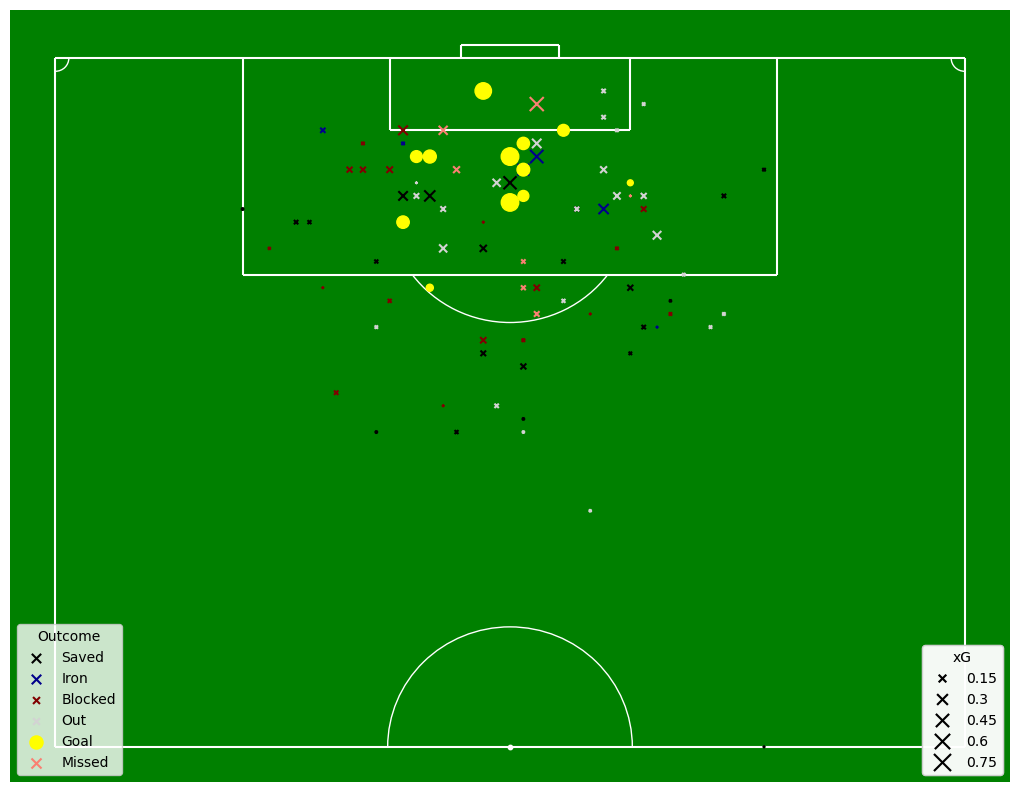

In [83]:
fig, ax = half_field()
colors = ["black", "darkblue", "maroon", "lightgrey", "yellow", "salmon"]
scatters = []

total = ax.scatter(shots.x_coord, shots.y_coord, 
               s=shots.sofascore_xG*200, alpha=1, 
               color="green", zorder=0, marker="x") 
for i, out in enumerate(shots.shot_outcome.unique()):
    if out == "Goal":
        marker = "o"
    else:
        marker = "x"
    cond = shots.shot_outcome == out
    scatters.append( ax.scatter(shots.x_coord[cond], shots.y_coord[cond], color=colors[i], 
               s=shots.sofascore_xG[cond]*200, zorder=2, label=out, marker=marker) )
outcome = plt.legend(scatters, shots.shot_outcome.unique(), 
                     loc="lower left", title="Outcome")
xg = plt.legend(total.legend_elements("sizes", num=6)[0], [0.15, 0.3 , 0.45, 0.6 , 0.75], 
                loc="lower right", markerscale=1, title="xG")

ax.add_artist(outcome)
ax.add_artist(xg)



In [84]:
sum(shots.sofascore_xG), sum(shots.shot_outcome == "Goal")

(12.46, 12)